Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


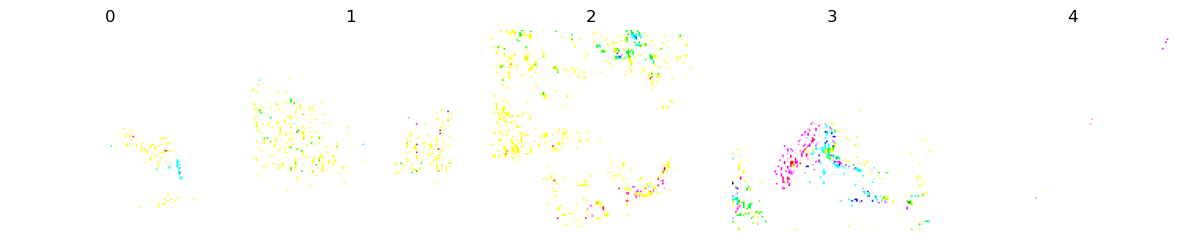

Epoch 1/10
 65/449 ━━━━━━━━━━━━━━━━━━━━ 4:22 684ms/step - accuracy: 0.5181 - loss: 0.6986

In [13]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

# Tamaño de las imágenes
IMG_SIZE = (128, 128)

# Función para comprimir una imagen usando JPEG
def jpeg_compression(image, quality=75):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

# Función para calcular la diferencia entre la imagen original y la recomprimida
def compute_diff(image):
    recompressed_image = jpeg_compression(image)
    diff_image = cv2.absdiff(image.astype(np.uint8), recompressed_image.astype(np.uint8))
    return diff_image

# Preparar el modelo CNN
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (7, 7), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

# Función para entrenar el modelo
def train_model(model, images, labels, epochs=10, batch_size=32):
    print(type(images))
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap='gray')  # Assuming images are grayscale
        plt.title(i)
        plt.axis('off')
    
    plt.show()
    
    diff_images = np.array([compute_diff(image) for image in images])
    diff_images = diff_images.astype('float32') / 255.0

    model.fit(diff_images, labels, epochs=epochs, batch_size=batch_size)

# Función para predecir si una imagen está manipulada
def predict_forgery(model, image):
    diff_image = compute_diff(image)
    diff_image = diff_image.astype('float32') / 255.0
    diff_image = np.expand_dims(diff_image, axis=0)
    prediction = model.predict(diff_image)
    return prediction

# Función para cargar una imagen TIFF
def load_tif_image(file_path):
    image = Image.open(file_path)
    image = image.convert('RGB')  # Asegurar que la imagen tenga 3 canales
    image_array = np.array(image)
    return tf.convert_to_tensor(image_array)

# Función para cargar una imagen desde el archivo
def load_image(file_path):
    if file_path.lower().endswith(('.tif', '.tiff')):
        image_tensor = load_tif_image(file_path)
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_tensor = tf.io.read_file(file_path)
        image_tensor = tf.image.decode_image(image_tensor, channels=3)  # Asegurar 3 canales
    resized = tf.image.resize(image_tensor, IMG_SIZE)
    return resized

# Función para obtener la lista de archivos y etiquetas
def get_file_list_and_labels(directory, label):
    file_list = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                file_list.append(os.path.join(root, file))
                labels.append(label)
    return file_list, labels

# Directorio donde se encuentran las imágenes genuinas y manipuladas
genuine_dir = '../data/CASIA2/Au'
tampered_dir = '../data/CASIA2/Tp'

# Cargar imágenes y etiquetas
genuine_files, genuine_labels = get_file_list_and_labels(genuine_dir, 0)
tampered_files, tampered_labels = get_file_list_and_labels(tampered_dir, 1)

# Unir listas de archivos y etiquetas
file_list = genuine_files + tampered_files
labels = genuine_labels + tampered_labels

# Cargar imágenes desde los archivos
images = [load_image(file).numpy() for file in file_list]
images = np.array(images)

# Convertir etiquetas a formato adecuado
labels = tf.keras.utils.to_categorical(labels, 2)

# Crear y entrenar el modelo
input_shape = (128, 128, 3)
model = create_cnn_model(input_shape)
train_model(model, images, labels)

# Predecir en una nueva imagen
#test_image_path = 'ruta/a/tu/imagen_de_prueba.tif'  # Reemplaza con la ruta a tu imagen de prueba
#test_image = load_tif_image(test_image_path)
#test_image = tf.image.resize(test_image, IMG_SIZE).numpy()

#prediction = predict_forgery(model, test_image)
#:", "Manipulada" if prediction[0][0] > prediction[0][1] else "Genuina")

